**MACS205a - Équations différentielles**

*Membres du groupe: ABUBAKER Rita, BERRONDO Alice, LY Timothée, PERSONNAZ Louis, TOURTOIS Eliott*

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Code

In [6]:
# Initial conditions
Atmosphere_Initial          = 750
CarbonateRock_Initial       = 100000000
DeepOcean_Initial           = 38000
FossilFuel_Initial          = 7500
Plant_Initial               = 560
Soil_Initial                = 1500
SurfaceOcean_Initial        = 890
VegLandArea_percent_Initial = 100

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Fossil fuels
FossFuelData = np.array([[50.0, 0.00],
                         [75.0, 0.30],
                         [100.0, 0.60],
                         [125.0, 1.35],
                         [150.0, 2.85],
                         [175.0, 4.95],
                         [200.0, 7.20],
                         [225.0, 10.05],
                         [250.0, 14.85],
                         [275.0, 20.70],
                         [300.0, 30.00]])

In [5]:
# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)

In [7]:
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

In [8]:
def derivative(x, t):
    Atmosphere          = x[0]
    CarbonateRock       = x[1]
    DeepOcean           = x[2]
    FossilFuelCarbon    = x[3]
    Plants              = x[4]
    Soils               = x[5]
    SurfaceOcean        = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial)) + (Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp
                    + SoilResp
                    + Volcanoes
                    + FossilFuelsCombustion_
                    - Photosynthesis
                    - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt = Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
    ])

    return derivative

In [9]:
x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial])

In [20]:
time = np.arange(0, 750, 1)
res = odeint(derivative, x0, time, full_output=1)

In [24]:
res[0].shape

(750, 8)

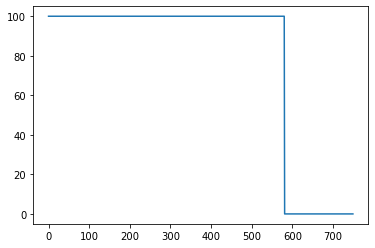

In [27]:
fig = plt.figure()
for param in range(res[0].shape[1]):
    if param == 7:
        plt.plot(time, res[0][:,param])
plt.show()